In [ ]:
from lambeq import BobcatParser, SpacyTokeniser, Rewriter, AtomicType, IQPAnsatz
from lambeq.backend.grammar import Diagram as grammatical_diagram
from lambeq.backend.quantum import Diagram as quantum_circuit
from typing import List, Optional, Tuple, Dict, Union

import os, time, multiprocessing

import nltk #how can i check if the tokens are correct? A: it doesn't matter

try:
    nltk.data.find('tokenizers/punkt_tab/french')
except LookupError:
    nltk.download('punkt_tab/french')
from nltk.tokenize import word_tokenize

os.environ["TOKENIZERS_PARALLELISM"] = "true" #environment variable for multithreading

#Global data sequencing variables
parser = BobcatParser(verbose="suppress")
tokeniser = SpacyTokeniser()
rewriter = Rewriter(['prepositional_phrase', 'determiner']) #potentially add more rules for rewrite
N = AtomicType.NOUN
S = AtomicType.SENTENCE
ansatz = IQPAnsatz({N:1,S:1}, n_layers=2, n_single_qubit_params=3)

num_processes = multiprocessing.cpu_count()
print(f"Using {num_processes} processes.")

def process_sentence(sentence: str, is_french: bool = False) -> Optional[Union[grammatical_diagram, List[str]]]:
    """
    A single sentence process, designed to be the base function for each process
    Args: String to process
    Returns: A semantic diagram of the sentence, or nothing
    """
    try:
        sentence = sentence.lower() #make all lowercase
        if is_french:
             tokens = word_tokenize(sentence, language='french') #switch english to ntlk tokenizer instead of spaCy? No, adds nothing
             return tokens #handling of french is done outside this code, so return None
            # rewritten_diagram = rewriter(diagram)
            # normalised_diagram = rewritten_diagram.normal_form()
            # return normalised_diagram
        else:
            #sentence = tokeniser.split_sentences(sentence) #for more complex sentences this will be needed, but breaks single sentence itterances
            tokens = tokeniser.tokenise_sentence(sentence)
            diagram = parser.sentence2diagram(tokens, tokenised=True)
            if diagram is not None:                
                rewritten_diagram = rewriter(diagram) # type: ignore[reportArgumentType]
                normalised_diagram = rewritten_diagram.normal_form()
                curry_functor = Rewriter(['curry'])
                curried_diagram = curry_functor(normalised_diagram) #another rewrite, this one is for map-state duality
                return curried_diagram
            else:
                return None

    except Exception as e:
        print(f"Failed to parse: {sentence}")
        return None

def process_sentences_batch(sentences: List[str], is_french: bool)-> List[Optional[Union[grammatical_diagram, List[str]]]]:
    """
    Processes a batch of sentences
    Args: List of sentences, is_french
    Returns: List of diagrams
    """
    return [process_sentence(sentence, is_french) for sentence in sentences]

def process_sentences(sentences: List[str], batch_size: int = 200, is_french: bool = False) -> Dict[int,Optional[grammatical_diagram]]:
    """
    Processes sentences in batches of 200(default only) in a parallel structure
    Args: sentences, list of strings
          batch_size number of sentences per batch
          is_french, flag set for second lang
    
    Returns:
        A dictionary of processed diagrams or none
    """
    start_time = time.time()
    diagrams: Dict[int, Optional[grammatical_diagram]] = {}
    with multiprocessing.Pool(processes=num_processes) as pool:
        indexed_sentences = list(enumerate(sentences))
        batches = [indexed_sentences[i:i + batch_size] for i in range(0, len(indexed_sentences), batch_size)]
        results = pool.map(lambda batch: {i: process_sentence(sentence, is_french) for i, sentence in batch}, batches) #lambda function to pass flag
        for result_dict in results:
            diagrams.update(result_dict)
        
    end_time = time.time()
    print(f"Processed {len(sentences)} sentences in {end_time - start_time: .2f} seconds using a batch size of {batch_size}.")
    return diagrams

def read_sentences_from_file(filename: str) -> List[str]:
    """
    Reads sentences from file
    Args: Filename, str
    Returns: list of sentences
    """
    try:
        
        with open(filename, "r", encoding="utf-8") as f:
            sentences = [line.strip() for line in f]
        return sentences
    
    except FileNotFoundError:
        print(f"Wrong file name")
        return [] #return Nullset for list item
    
    except UnicodeDecodeError:
        print(f"missed utf-8 encoding")
        return []
    
    except Exception as e:
        print(f"Unknown Error")
        return []
    
def convert_diagram(diagram:Optional[grammatical_diagram], is_french: bool = False) -> Optional[quantum_circuit]:
    """Converts a diagram to it's equivilant quantum circuit

    Args:
        diagram (Optional[object]): Diagram Obj

    Returns:
        Optional[object]: Circuit obj, or None
    """
    if diagram is None:
        return None
    if is_french:
        return NotImplemented #function to make french diagrams in progress
    try:
        circuit = ansatz(diagram) #error is only because diagram for french circuits is not finished
        return circuit
    except Exception as e:
        print("Failed to convert diagram to circuit")
        return None
    
def convert_diagrams_batch(diagrams: List[Optional[grammatical_diagram]], is_french: bool=False) -> List[Optional[quantum_circuit]]:
    return [convert_diagram(diagram, is_french) for diagram in diagrams]

def process_diagrams(diagrams: Dict[int, Optional[grammatical_diagram]], is_french: bool=False, batch_size: int = 200) -> Dict[int, Optional[quantum_circuit]]:
    """Converts diagrams to circuits in batches parallelizing the work, while maintaining original sentence indicies

    Args:
        diagrams: Dictionary mapping sentence indices to diagram for efficent storage
        batch_size (int, optional): number of diagrams per batch

    Returns:
        Dict[int, Optional[object]]: _description_A dictionary mapping sentence indicies to circuits
    """
    start_time = time.time()
    
    indicies = list(diagrams.keys())
    batched_indices = [indicies[i:i + batch_size] for i in range(0, len(indicies), batch_size)]
   
    circuits: Dict[int,Optional[quantum_circuit]] = {}
    
    with multiprocessing.Pool(num_processes) as pool:
        results = []
        for index_batch in batched_indices:
            diagram_batch = [diagrams.get(index) for index in index_batch]
            is_french_batch = [is_french for index in index_batch]
            results.append(pool.apply_async(convert_diagrams_batch, args=(diagram_batch, is_french_batch)))
        
        for result in results:
            results_dict = dict(zip(indicies, result.get()))
        #reconstruct dictionary
    circuit_index = 0
    for i, index_batch in enumerate(batched_indices):
        results_batch = results[i].get()
        for j, index in enumerate(index_batch):
                circuits[index] = results_batch[j]
                
    end_time = time.time()
    print(f"Converted {len(diagrams)} diagrams to circuits in {end_time - start_time:.2f} seconds using batch size of {batch_size}.")
    return circuits

def save_circuit(circuit: Optional[quantum_circuit], filename:str) -> None:
    """Saves a single diagram to a file."""
    try:
        if circuit is None:
            print(f"Warning quantum_circuit missing, Skipping {filename}.")
            return
        else:
            circuit.draw(path=filename, figsize=(20,20), draw_type_labels=False)
            return
    except Exception as e:
        print(f"An error occurred while saving {filename}: {e}")
        
def create_circuit_pairs(english_circuits: Dict[int, Optional[quantum_circuit]], french_circuits: Dict[int, Optional[quantum_circuit]]) -> List[Tuple[Optional[quantum_circuit], Optional[quantum_circuit]]]:
    """
    Pairs English and french circuits based on their original sentence indices.

    Args:
        english_circuits: Dictionary mapping English sentence indices to circuits.
        french_circuits: Dictionary mapping french sentence indices to circuits.

    Returns:
        A list of tuples, where each tuple contains an (English circuit, french circuit) pair.
        Only pairs with matching indices are included.  If a circuit is missing for a given
        index in either language, that index is skipped.
    """
    circuit_pairs: List[Tuple[Optional[quantum_circuit], Optional[quantum_circuit]]] = []
    common_indices = sorted(list(english_circuits.keys() & french_circuits.keys()))  # Get sorted common indices

    for index in common_indices: #if left or right is None, it will be skipped
        en_circuit = english_circuits.get(index)
        fr_circuit = french_circuits.get(index)
        circuit_pairs.append((en_circuit, fr_circuit))

    return circuit_pairs

Using 12 processes.


In [ ]:
#load data
import pandas as pd
def load_translation_data(csv_file):
    """Loads English and French sentences from a CSV file

    Args:
        csv_file (str): Path to csv_file
    Returns:
        tuple: A typle containing english/french pairs
        returns [],[] on error
    """
    english_sentences=[]
    french_sentences = []
    
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
        print("Column names:", df.columns)
        english_sentences_series = df['English words/sentences']
        french_sentences_series = df['French words/sentences']
        english_sentences = english_sentences_series.tolist()
        french_sentences = french_sentences_series.tolist()
        
        print(f"Loaded {len(english_sentences)} English sentences and {len(french_sentences)} French sentences.")
        return english_sentences,french_sentences
        
    except FileNotFoundError:
        print("Wrong Path")
        return [],[]
    
    except Exception as e:
        print(f"An {e} Error Occurred")
        return [],[]

DATA_PATH = r'C:/Users/Jash/Documents/Research/QNLP/eng_-french.csv'
english_sentences, french_sentences = load_translation_data(DATA_PATH)

def write_fr_tokens(fr_sentences: List[str], output_path: str) -> None:
    """Turns the french sentences  into tokens
    Args: fr_sentences (List[str]): data to be converted
            output_path (str): path to save the data
    Returns: None
    """
    try:
        with open(output_path, 'w', encoding='utf-8') as outfile:
            for sentence in fr_sentences:
                tokens = process_sentence(sentence,is_french=True)
                if tokens:
                    if isinstance(tokens, list) and all(isinstance(token, str) for token in tokens):
                        outfile.write(' '.join(tokens) + '\n') #puts back into sentence form
                else:
                    outfile.write('\n ')
    except Exception as e:
        print(f"An {e} error occurred")


Column names: Index(['English words/sentences', 'French words/sentences'], dtype='object')
Loaded 175621 English sentences and 175621 French sentences.


In [ ]:
#Load Data into memory (english and french) english is now handled separately
write_fr_tokens(french_sentences, output_path="fr_tokens.txt") #first step of french pipeline #tokenize (done outside main fx)
#parse french (done inside the berkleyparser)
#maybe some manual find/replace on the ccg_file
#do pregroup on ccg file 
#generate the tree (discopy or lambeq)
#same flow as english from this point on

NameError: name 'write_fr_tokens' is not defined

In [ ]:
#Create/save english circuits full pipeline 5GB of images cpu only (gpu not used)
english_diagrams=[]
english_circuits=[]
for i,sentence in enumerate(english_sentences):
    diagram = process_sentences(english_sentences[i])
    english_diagrams.append(diagram)
    circuit = process_diagrams(english_diagrams[i])
    english_circuits.append(circuit) #am i happy with these circuits? labels? lines? color? Different Ansantz?
    filename = f"english_circuits/english_circuit_{i+1}.png"
    save_circuit(english_circuits[i], filename)

Failed to convert diagram to circuit
Warning quantum_circuit missing, Skipping english_circuits/english_circuit_487.png.
Failed to convert diagram to circuit
Warning quantum_circuit missing, Skipping english_circuits/english_circuit_860.png.
Failed to convert diagram to circuit
Warning quantum_circuit missing, Skipping english_circuits/english_circuit_861.png.
Failed to convert diagram to circuit
Warning quantum_circuit missing, Skipping english_circuits/english_circuit_862.png.
Failed to convert diagram to circuit
Warning quantum_circuit missing, Skipping english_circuits/english_circuit_863.png.
Failed to convert diagram to circuit
Warning quantum_circuit missing, Skipping english_circuits/english_circuit_864.png.
Failed to convert diagram to circuit
Warning quantum_circuit missing, Skipping english_circuits/english_circuit_1089.png.
Failed to convert diagram to circuit
Warning quantum_circuit missing, Skipping english_circuits/english_circuit_1090.png.
Failed to convert diagram to c

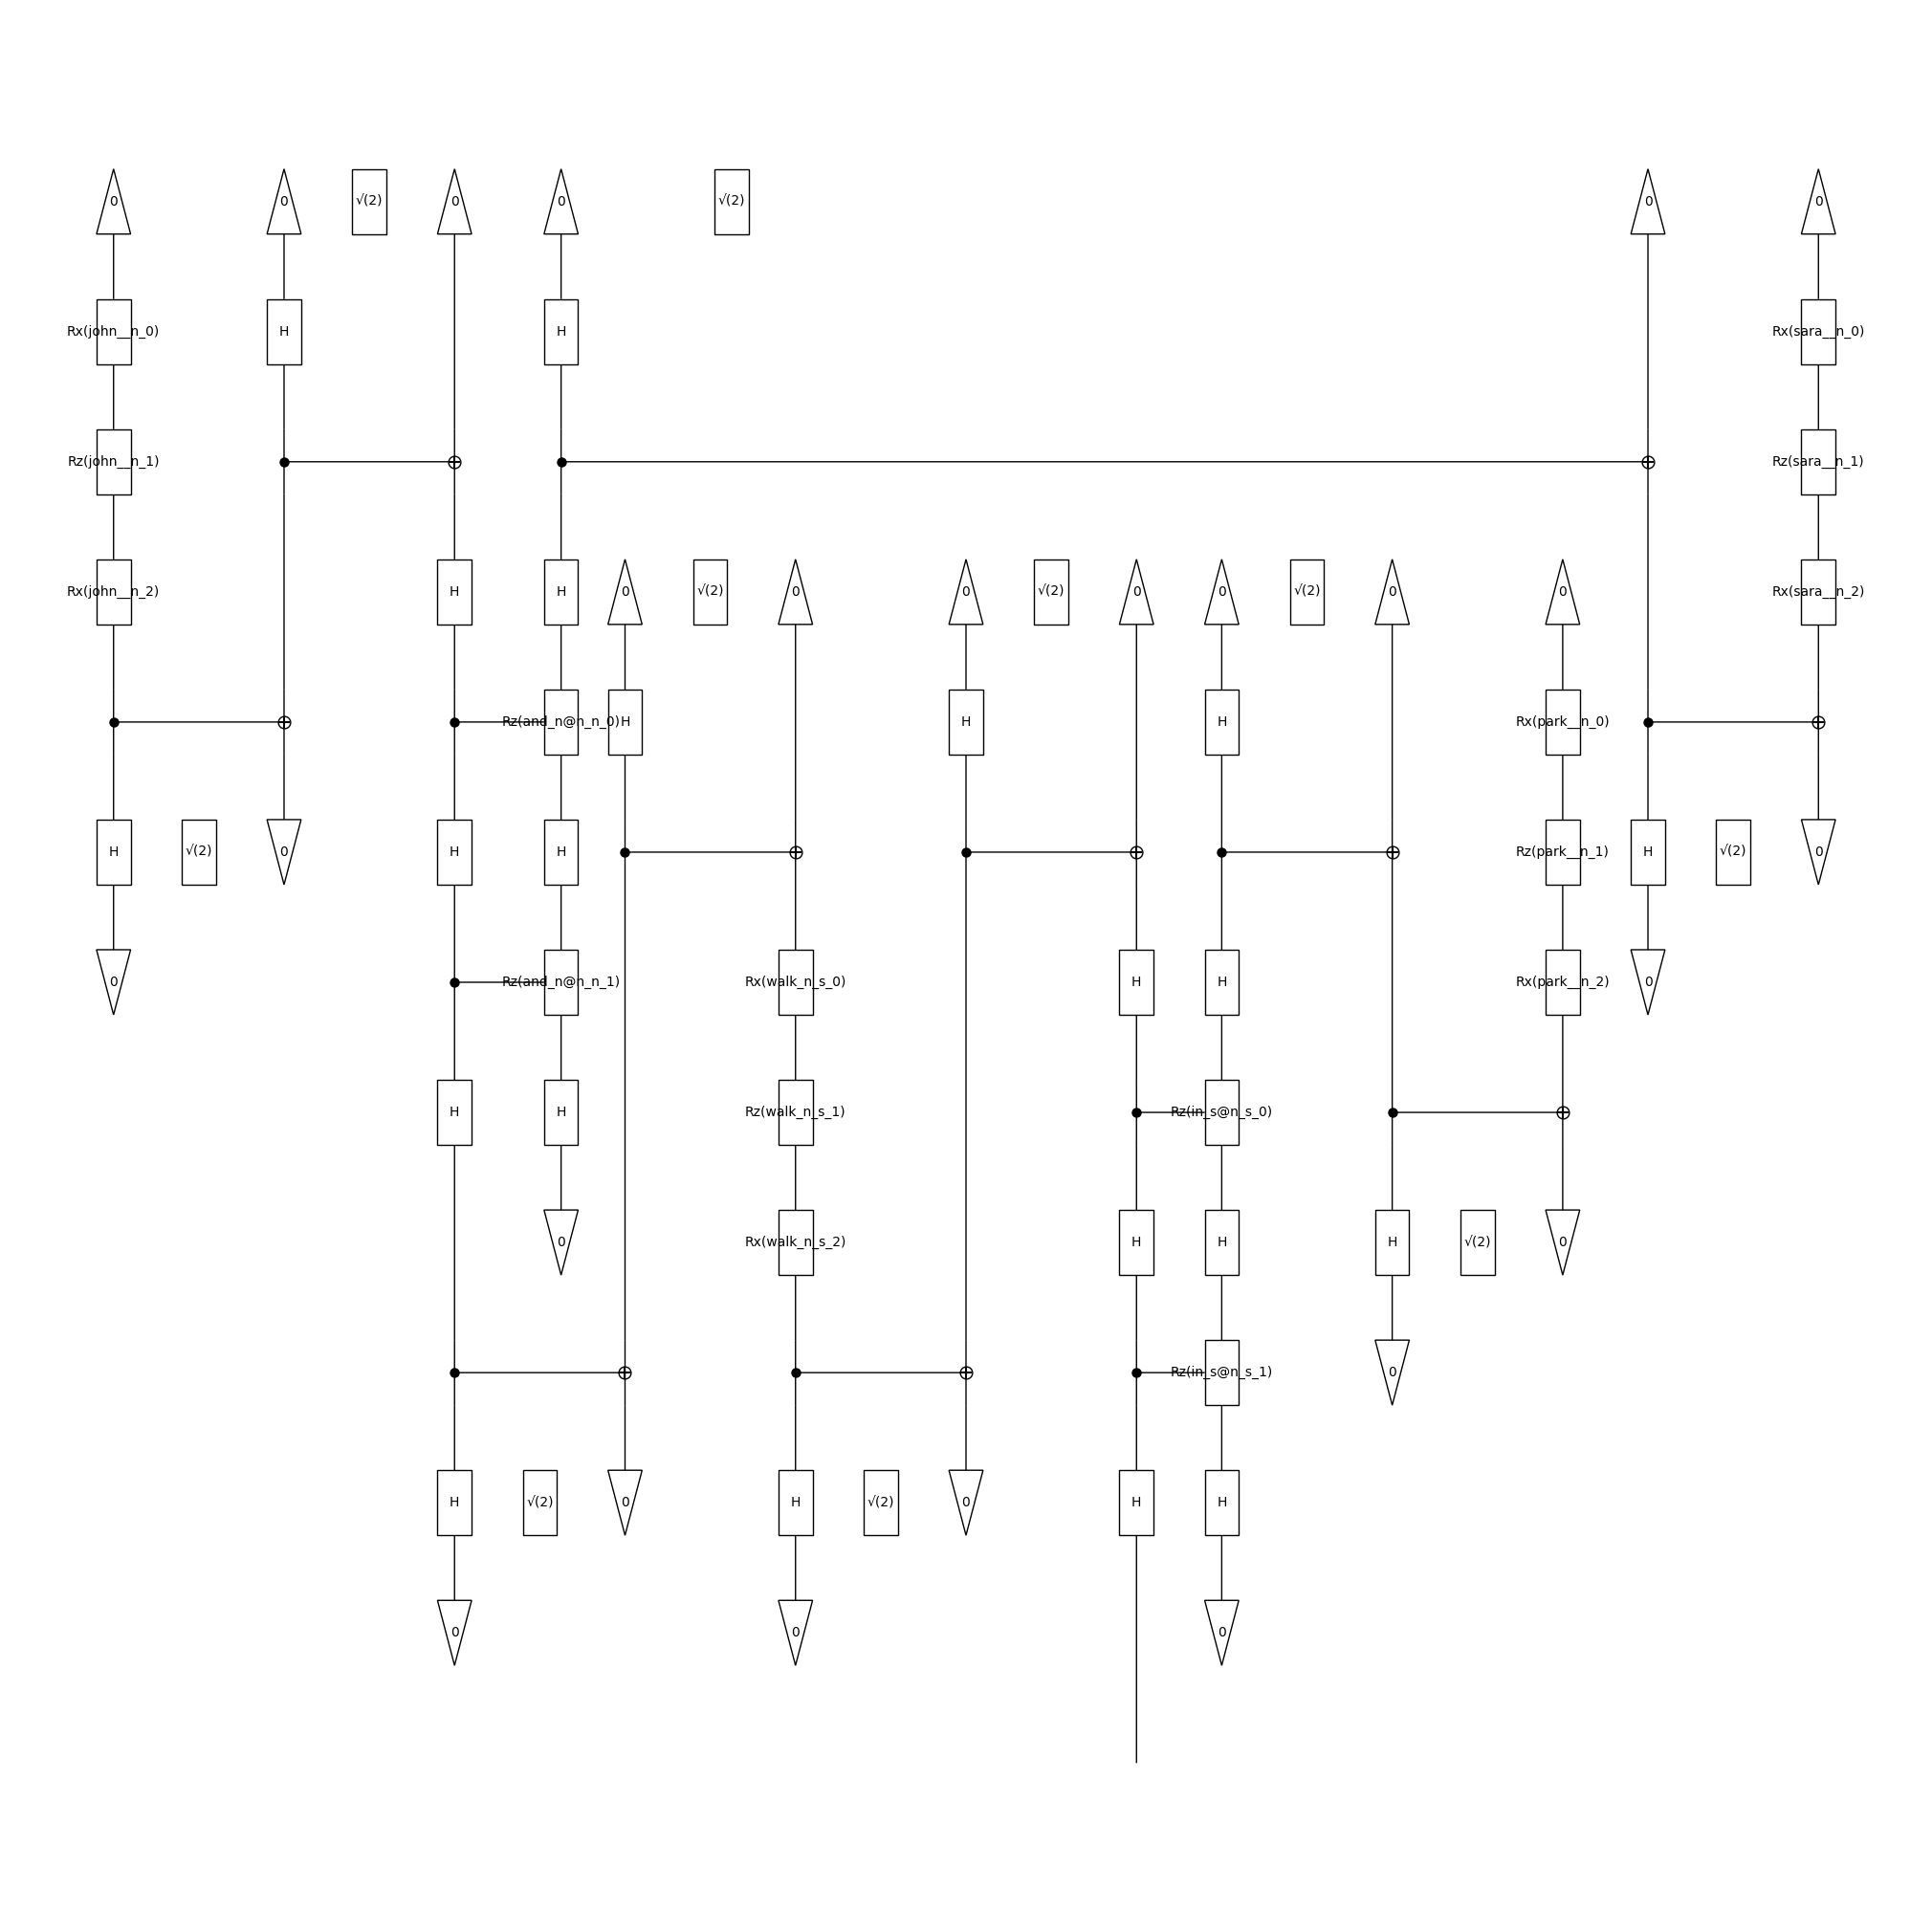

In [8]:
sentence1 = process_sentence("John and Sara walk in the park.")
#sentence1.draw(figsize=(20,20), draw_type_labels=False)
circuit1 = convert_diagram(sentence1)
#print(circuit1)
circuit1.draw(figsize=(20,20), draw_type_labels=False)

In [ ]:
from lambeq import CCGTree
#lambeq diagram -> ccg -> combinatory categorial grammar category theory that turns sentences into functions/trees ccgtree, types
def create_lambeq_diagram(ccg_parse_string):
    """
    Converts a CCG parse string to a lambeq CCGTree and then a diagram.

    Args:
        ccg_parse_string (str): A string representing a CCG parse.

    Returns:
        lambeq.diagram.Diagram: The lambeq diagram, or None if parsing fails.
    """
    try:

        # Create a CCGTree from the string
        #tree = CCGTree.fromstring(ccg_parse_string) #from_string doesn't exist, but from_JSON DOES

        # Convert the CCGTree to a diagram
        #diagram = tree.to_diagram()  # Or tree.to_biclosed_diagram(), depending on your needs

        return diagram

    except Exception as e:
        print(f"Error processing parse '{ccg_parse_string}': {e}")
        return None

fr_ccg = read_sentences_from_file("FR_CCG.txt")
for sentence in fr_ccg:
    create_lambeq_diagram(sentence)
    

##### MACHINE LEARNING STARTS HERE #####

In [ ]:
import torch
from torch import nn
from lambeq import PennyLaneModel, Dataset, BobcatParser, RemoveCupsRewriter
import random
import numpy as np

#hyperparameters
BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.1
SEED = 42
test_size = 0.2
val_size = 0.125
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

import torch
import random
import numpy as np
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


In [ ]:
from sklearn.model_selection import train_test_split
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

def split_data(eng_sentences,fr_sentences):   #likely to put the circuits into this function, not the sentences
    eng_train, eng_test, fr_train, fr_test  = train_test_split(eng_sentences, fr_sentences, test_size=test_size, random_state=SEED)
    relative_val_size = val_size / (1 - test_size)
    #split for validation

    eng_train, eng_val, fr_train, fr_val = train_test_split(eng_train, fr_train, test_size=relative_val_size, random_state=SEED)
    print(list(zip(eng_train[:5], fr_train[:5])))
    return eng_train, eng_test, eng_val, fr_train, fr_test, fr_val

#eng_train, eng_test, eng_val, fr_train, fr_test, fr_val = split_data(eng_sentences,fr_sentences)
#classical simulation of quantum circuits




In [ ]:
# from lambeq import PennyLaneModel


# backend_config = {'backend': 'default.qubit'}
# model = PennyLaneModel.from_diagrams(ml_data, probabilities=True, normalize=True,backend_config=backend_config)
# #model.initialise_weights()

In [ ]:
# from lambeq import PytorchTrainer

# trainer = PytorchTrainer(
#     model=model,
#     loss_function=loss,
#     optimizer=torch.optim.Adam,
#     learning_rate=LEARNING_RATE,
#     epochs=EPOCHS,
#     evaluate_functions={'acc': acc},
#     evaluate_on_train=True,
#     use_tensorboard=False,
#     verbose='text',
#     seed=SEED)

In [ ]:
# import pennylane as qml
# qml.default_config['qiskit.ibmq.ibmqx_token'] = 'my_API_token'
# qml.default_config.save(qml.default_config.path)
# backend_config = {'backend': 'qiskit.ibmq',
#                   'device': 'ibmq_manilia',
#                   'shots': 1000}
# #q_model = PennyLaneModel.from_diagrams(ml_data, probabilities=True, normalize=True, backend_config=backend_config)
# #q_model = initialise_weights()

In [ ]:

#trainer.fit(train_dataset, val_dataset)